In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, MaxPooling2D, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
import visualkeras

2022-11-22 17:32:08.118000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 17:32:08.231189: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-22 17:32:08.602076: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yisan/anaconda3/envs/gpu_env/lib/
2022-11-22 17:32:08.602120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_pl

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable first GPU
  tf.config.set_visible_devices(physical_devices[0], 'GPU')
  logical_devices = tf.config.list_logical_devices('GPU')
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass


2022-11-22 17:32:09.431557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 17:32:09.436097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 17:32:09.436517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 17:32:09.437653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2022-11-22 17:32:09.869737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 17:32:09.870366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 17:32:09.870723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 17:32:09.871157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 17:32:09.871620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [5]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

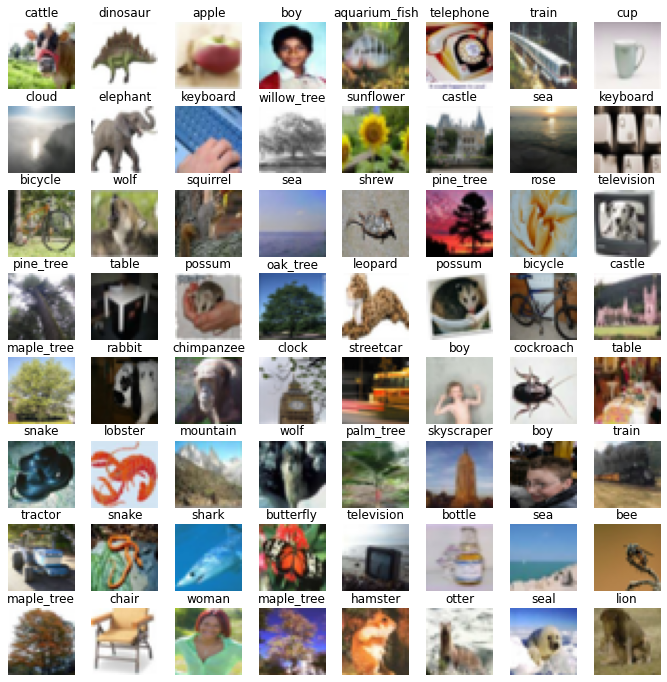

In [6]:
class_list = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

fig = plt.figure(figsize=(12, 12))
ax = [fig.add_subplot(8, 8, i+1) for i in range(8*8)]

for i, a in enumerate(ax):
    a.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    a.set_aspect('equal')
    a.set_title(class_list[y_train[i][0]])
    a.axis('off')

plt.subplots_adjust(wspace=0, hspace=0.25)



plt.show()

In [7]:
dg = ImageDataGenerator(width_shift_range=0.15, 
                        height_shift_range=0.15,
                        horizontal_flip=True)

itr = dg.flow(X_train, y_train, batch_size=X_train.shape[0], shuffle=True)

X, y = itr.next()

X_train = np.concatenate((X_train, X), axis=0)
y_train = np.concatenate((y_train, y))
X_train, y_train = shuffle(X_train, y_train)

In [8]:
y_train = to_categorical(y_train).astype('float32')
y_test = to_categorical(y_test).astype('float32')

In [9]:
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [10]:
def create_model(optimizer, dropout_rate):
    opt = optimizer()
    nine_layer_conv = Sequential()

    nine_layer_conv.add(Conv2D(32, 3, input_shape=(32, 32, 3), activation='relu'))
    nine_layer_conv.add(BatchNormalization())
    nine_layer_conv.add(Dropout(rate=dropout_rate))

    nine_layer_conv.add(Conv2D(32, 3, activation='relu'))
    nine_layer_conv.add(BatchNormalization())
    nine_layer_conv.add(Dropout(rate=dropout_rate))

    nine_layer_conv.add(Conv2D(32, 3, activation='relu'))
    nine_layer_conv.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
    nine_layer_conv.add(BatchNormalization())
    nine_layer_conv.add(Dropout(rate=dropout_rate))
    

    nine_layer_conv.add(Conv2D(64, 3, activation='relu'))
    nine_layer_conv.add(BatchNormalization())
    nine_layer_conv.add(Dropout(rate=dropout_rate))

    nine_layer_conv.add(Conv2D(64, 3, activation='relu'))
    nine_layer_conv.add(BatchNormalization())
    nine_layer_conv.add(Dropout(rate=dropout_rate))

    nine_layer_conv.add(Conv2D(64, 3, activation='relu'))
    nine_layer_conv.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
    nine_layer_conv.add(BatchNormalization())
    nine_layer_conv.add(Dropout(rate=dropout_rate))


    nine_layer_conv.add(Conv2D(128, 3, activation='relu'))
    nine_layer_conv.add(BatchNormalization())
    nine_layer_conv.add(Dropout(rate=dropout_rate))

    nine_layer_conv.add(Conv2D(128, 3, activation='relu'))
    nine_layer_conv.add(BatchNormalization())
    nine_layer_conv.add(Dropout(rate=dropout_rate))

    nine_layer_conv.add(Conv2D(128, 3, activation='relu'))
    nine_layer_conv.add(BatchNormalization())
    nine_layer_conv.add(Dropout(rate=dropout_rate))

    nine_layer_conv.add(Flatten())

    nine_layer_conv.add(Dense(200, activation='relu'))
    nine_layer_conv.add(Dense(100, activation='softmax'))

    nine_layer_conv.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return nine_layer_conv

In [13]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=create_model)

params = {'optimizer': [Adam, SGD], 'dropout_rate': [0, 0.1, 0.2, 0.3]}
random_search = GridSearchCV(model, param_grid=params, cv=KFold(3))

es = EarlyStopping(monitor='accuracy', patience=5, min_delta=0.005)

random_search.fit(X_train_1, y_train_1, batch_size=32, epochs=50, callbacks=[es])

random_search.best_params_

/tmp/ipykernel_53554/1075998126.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


Epoch 1/50


2022-11-22 17:34:33.717633: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 548855808 exceeds 10% of free system memory.
2022-11-22 17:34:33.989340: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 548855808 exceeds 10% of free system memory.


1396/1396 [==============================] - 15s 10ms/step - loss: 0.0723 - accuracy: 0.0535
Epoch 2/50
1396/1396 [==============================] - 13s 10ms/step - loss: 0.0493 - accuracy: 0.1097
Epoch 3/50
1396/1396 [==============================] - 13s 10ms/step - loss: 0.0466 - accuracy: 0.1442
Epoch 4/50
1396/1396 [==============================] - 13s 10ms/step - loss: 0.0442 - accuracy: 0.1796
Epoch 5/50
1396/1396 [==============================] - 13s 10ms/step - loss: 0.0418 - accuracy: 0.2176
Epoch 6/50
1396/1396 [==============================] - 14s 10ms/step - loss: 0.0398 - accuracy: 0.2548
Epoch 7/50
1396/1396 [==============================] - 14s 10ms/step - loss: 0.0381 - accuracy: 0.2854
Epoch 8/50
1396/1396 [==============================] - 14s 10ms/step - loss: 0.0365 - accuracy: 0.3174
Epoch 9/50
1396/1396 [==============================] - 14s 10ms/step - loss: 0.0349 - accuracy: 0.3461
Epoch 10/50
1396/1396 [==============================] - 14s 10ms/step - lo

2022-11-22 17:45:19.699390: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 548868096 exceeds 10% of free system memory.


1396/1396 [==============================] - 15s 10ms/step - loss: 0.0709 - accuracy: 0.0560
Epoch 2/50
1396/1396 [==============================] - 14s 10ms/step - loss: 0.0484 - accuracy: 0.1225
Epoch 3/50
1396/1396 [==============================] - 14s 10ms/step - loss: 0.0462 - accuracy: 0.1586
Epoch 4/50
1396/1396 [==============================] - 14s 10ms/step - loss: 0.0434 - accuracy: 0.1973
Epoch 5/50
1396/1396 [==============================] - 13s 10ms/step - loss: 0.0412 - accuracy: 0.2314
Epoch 6/50
1396/1396 [==============================] - 13s 10ms/step - loss: 0.0392 - accuracy: 0.2631
Epoch 7/50
1396/1396 [==============================] - 13s 10ms/step - loss: 0.0374 - accuracy: 0.2970
Epoch 8/50
1396/1396 [==============================] - 13s 10ms/step - loss: 0.0358 - accuracy: 0.3302
Epoch 9/50
1396/1396 [==============================] - 13s 10ms/step - loss: 0.0341 - accuracy: 0.3647
Epoch 10/50
1396/1396 [==============================] - 13s 10ms/step - lo

In [ ]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
filepath = 'modelcheckpoint/nine_layer_conv_regularization.h5'
model = create_model(learning_rate=0.001, l2_3=0.0001, l2_2=1e-06, l2_1=1e-06, l1_3=1e-06, l1_2=1e-05, l1_1=1e-06)
mc = ModelCheckpoint(filepath=filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)
model_history = model.fit(X_train_1, y_train_1, batch_size=256, epochs=100, validation_data=(X_val, y_val), callbacks=[mc])

Epoch 1/100
262/262 [==============================] - 14s 48ms/step - loss: 0.1446 - accuracy: 0.0772 - val_loss: 0.1175 - val_accuracy: 0.0202
Epoch 2/100
262/262 [==============================] - 12s 46ms/step - loss: 0.0927 - accuracy: 0.1322 - val_loss: 0.0865 - val_accuracy: 0.0704
Epoch 3/100
262/262 [==============================] - 12s 45ms/step - loss: 0.0733 - accuracy: 0.1666 - val_loss: 0.0672 - val_accuracy: 0.1263
Epoch 4/100
262/262 [==============================] - 12s 45ms/step - loss: 0.0589 - accuracy: 0.1983 - val_loss: 0.0581 - val_accuracy: 0.1544
Epoch 5/100
262/262 [==============================] - 12s 45ms/step - loss: 0.0529 - accuracy: 0.2181 - val_loss: 0.0520 - val_accuracy: 0.1963
Epoch 6/100
262/262 [==============================] - 12s 45ms/step - loss: 0.0501 - accuracy: 0.2422 - val_loss: 0.0580 - val_accuracy: 0.1686
Epoch 7/100
262/262 [==============================] - 12s 45ms/step - loss: 0.0477 - accuracy: 0.2674 - val_loss: 0.0502 - val_ac

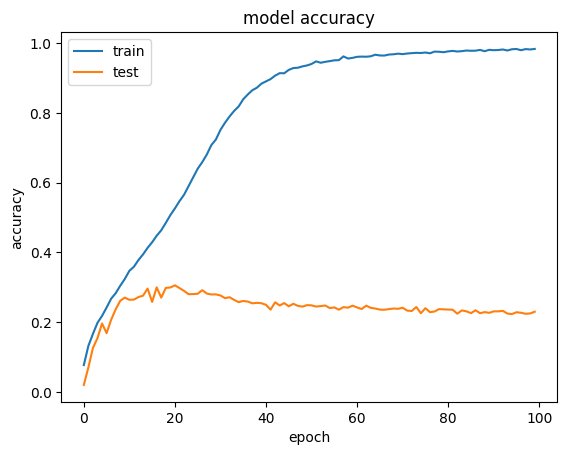

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

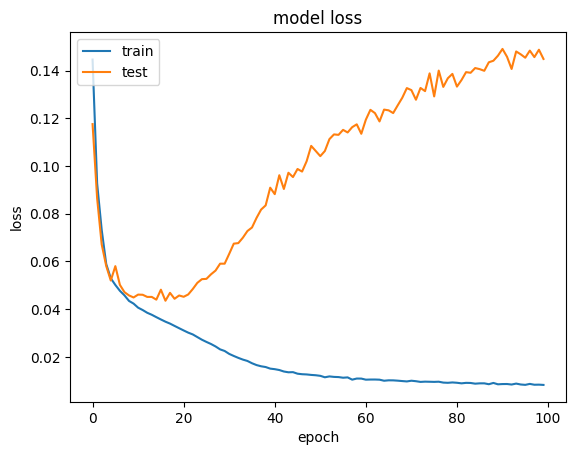

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = create_model(learning_rate=0.001, l2_3=0.0001, l2_2=1e-06, l2_1=1e-06, l1_3=1e-06, l1_2=1e-05, l1_1=1e-06)
model.load_weights(filepath)

loss, acc = model.evaluate(X_test, y_test)

print({acc}, loss)

313/313 [==============================] - 3s 7ms/step - loss: 0.0445 - accuracy: 0.3260
0.32600000500679016 0.04454313963651657
